In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.contrib import lite
#tf.enable_eager_execution()

from glob import glob

from sklearn.preprocessing import normalize
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

from tensorflow.python.platform import gfile



In [2]:
use_rotation_sensor = False
use_accelerometer_sensor = True
use_gyroscope_sensor = True
use_magnetic_sensor = False
sensor_inputs = 0
normalize_vector = np.array([])

if use_rotation_sensor:
    sensor_inputs += 5
    normalize_vector = np.append(normalize_vector, [1,1,1,1,1], axis=0)

if use_accelerometer_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [15,15,15], axis=0)
    
if use_gyroscope_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [3,3,3], axis=0)

if use_magnetic_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [40,40,40], axis=0)


cut_shape = (100, sensor_inputs)
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}


data_folder = "data/"
patterns = {"left" : "swipe_left_20*.mkv", "right" : "swipe_right_20*.mkv", "noise" : "*noise*.mvk"} 
data_split_folder = "data_singled/"

In [3]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        prev_sensor_channels = 0
        if len(df_i) < 100:
            continue
        if use_rotation_sensor:
            df_cut_list[i, : , 0:5] = df_i.iloc[0: 100, 0:5]
            prev_sensor_channels += 5
        if use_accelerometer_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 5:8]
            prev_sensor_channels += 3
        if use_gyroscope_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 8:11]
            prev_sensor_channels += 3
        if use_magnetic_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 11:14]
            prev_sensor_channels += 3
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 8
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for cut in cuts:
            plt.plot(cut)
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

In [4]:
for gesture in patterns.keys():
    break
    gesture_file_list = glob(data_folder + patterns[gesture])
    k = 0
    for filename in gesture_file_list:
        print(filename)
        df, col_name_tpls = read_file(filename)
        df["Cywee Accelerometer Sensor_2"].plot()
        plt.show()
        start = int(input("start?"))
        end = int(input("end?"))
        trimed_df = trim_data(df, start, end)
        peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
        print(len(peaks), ":", peaks)
        cuts = normalize_cuts(cut_data(trimed_df, peaks))
        print("Found cuts:", len(cuts))
        plot_cuts(cuts)
        r = eval(input("remove cuts?? (divide by \',\') "))
        assert type(r) == list
        cuts_copy = [cut for cut in cuts]
        for cut in r:   # cuts to remove from the list:
            cur_cut = cuts_copy[cut]
            print(cuts[3:10].where(cur_cut))
        break
    break

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


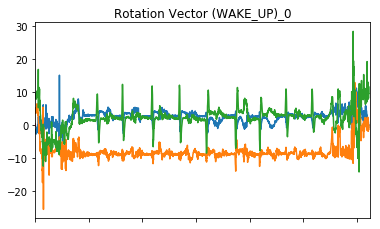

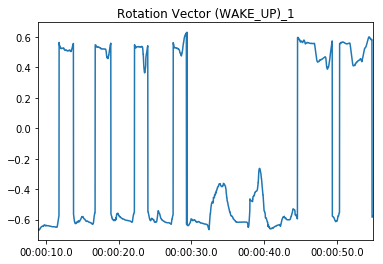

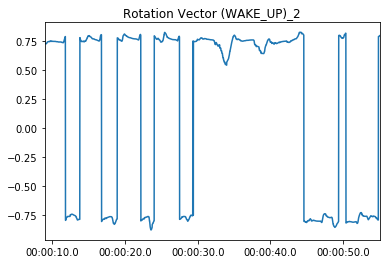

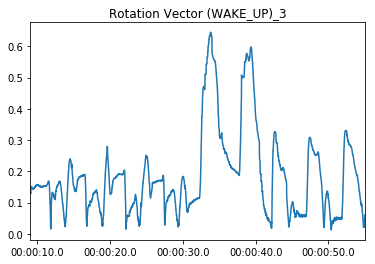

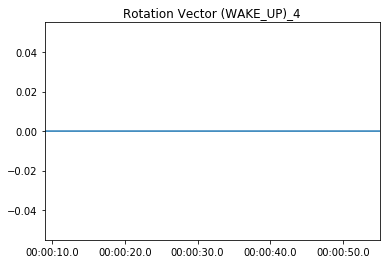

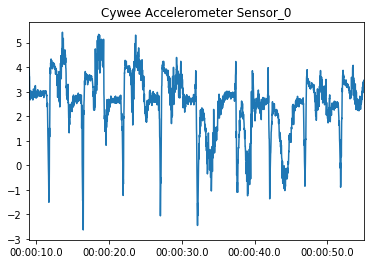

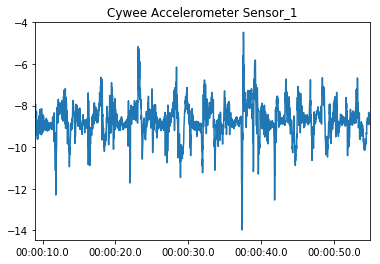

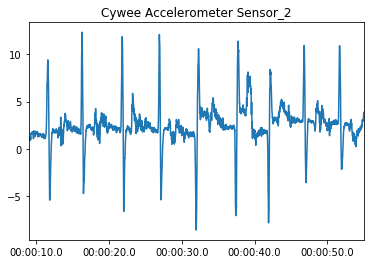

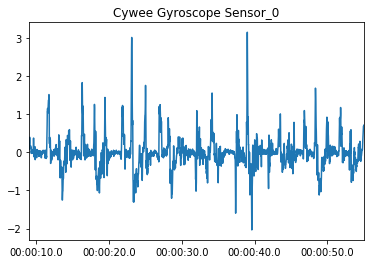

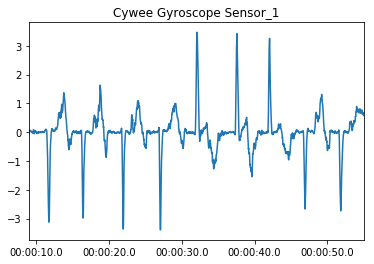

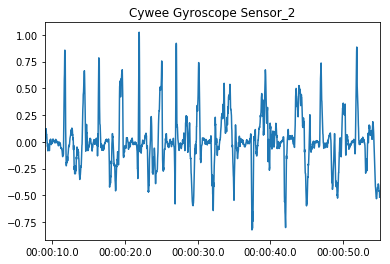

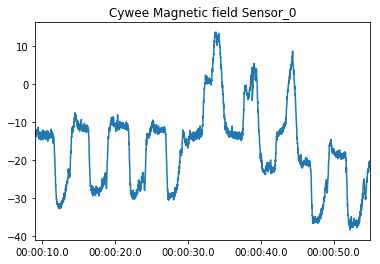

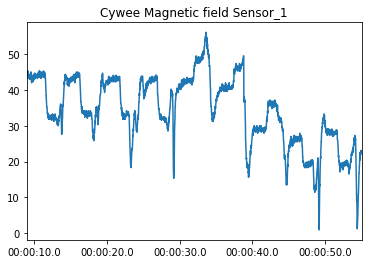

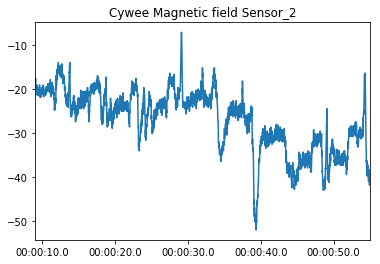

9 : [(10.54, 12.54), (15.239999999999998, 17.24), (20.76, 22.76), (25.86, 27.86), (31.22, 33.22), (36.64, 38.64), (41.14, 43.14), (45.74, 47.74), (50.64, 52.64)]
Found cuts: 9


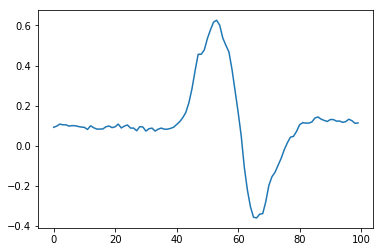

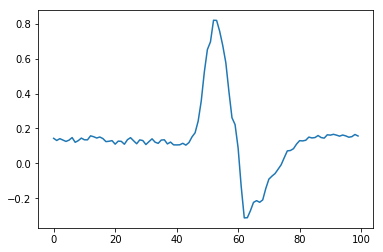

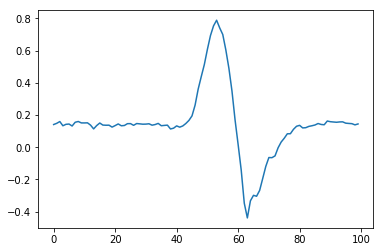

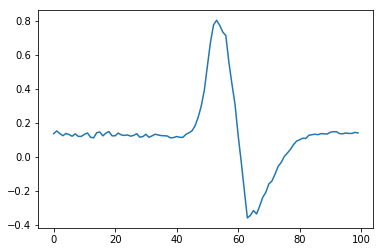

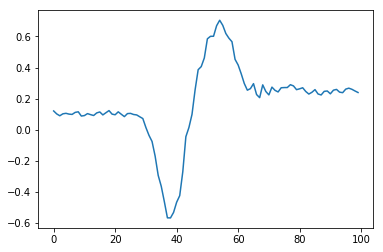

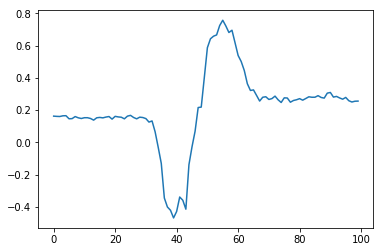

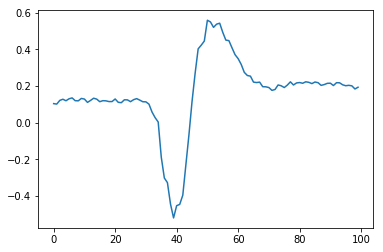

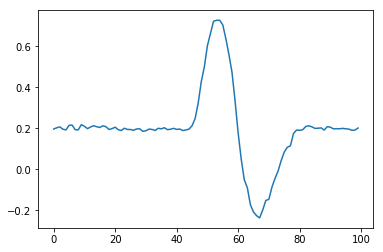

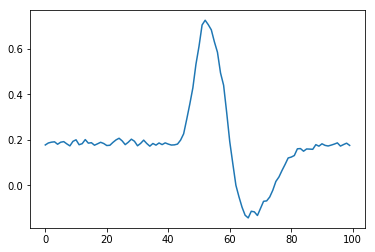

In [20]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 9, 55)
plt.plot(df.iloc[:, 5:8])
plt.savefig('tmp_fig.png')
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [5]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    
    output_graph_name = "kreas_model" + '.pb'
    output_graph_suffix = '_inference'
    
    return model

    
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph



In [6]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [9]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20_0.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 6)
DataShape: (9, 100, 6)
DataShape: (18, 100, 6)
Noiseshape: (50, 100, 6)
Learn L shape: (27, 100, 6)
Learn data has shape: (86, 100, 6)
(86, 100, 6)
Epoch 1/50
86/86 [==============================] - 0s 1ms/sample - loss: 0.7687 - acc: 0.6279
Epoch 2/50
86/86 [==============================] - 0s 152us/sample - loss: 0.2412 - acc: 0.9419
Epoch 3/50
86/86 [==============================] - 0s 140us/sample - loss: 0.1160 - acc: 0.9651
Epoch 4/50
86/86 [==============================] - 0s 141us/sample - loss: 0.0677 - acc: 0.9767
Epoch 5/50
86/86 [==============================] - 0s 158us/sample - loss: 0.0424 - acc: 0.9884
Epoch 6/50
86/86 [==============================] - 0s 154us/sample - loss: 0.0239 - acc: 1.0000
Epoch 7/50
86/86 [==============================] - 0s 143us/sample - loss: 0.0180 - acc: 1.0000
Epoch 8/50
86/86 [==============================] - 0s 165us/sample - loss: 0.0131 - acc: 1.0000
Epoch 9/50
86/86 [==============================] - 0s 

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [10]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_1.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 6)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (5, 100, 6)
Noise
Noise
Noise
Noise
Noise


In [11]:
model.save('keras_gesture_model.h5')

converter = lite.TFLiteConverter.from_keras_model_file('keras_gesture_model.h5')
tfmodel = converter.convert()
open ("keras_gesture_model.tflite" , "wb") .write(tfmodel)

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


1450684

In [92]:
for p in predictions:
    print(max(p))

0.999925
0.9998023
0.99985456
0.9998716
0.99164516
0.9969029
0.99372137
0.99981433
0.99985874


In [93]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

classified as left or right with confidence 85.07%
classified as noise, 0.76335883
classified as noise, 0.6150805
classified as noise, 0.7342927
classified as noise, 0.6838825
classified as left or right with confidence 50.05%
classified as left or right with confidence 56.37%
classified as left or right with confidence 54.07%
classified as left or right with confidence 54.33%
classified as left or right with confidence 53.99%
classified as left or right with confidence 57.87%
classified as left or right with confidence 53.98%
classified as left or right with confidence 78.90%
classified as left or right with confidence 99.51%
classified as noise, 0.66675365
classified as left or right with confidence 89.48%
classified as noise, 0.6293211
classified as noise, 0.9918406


# Save graph

https://medium.com/@thepulkitagarwal/deploying-a-keras-model-on-android-3a8bb83d75ca
https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb
https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc
https://blog.metaflow.fr/tensorflow-saving-restoring-and-mixing-multiple-models-c4c94d5d7125


In [17]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
    
tf.train.write_graph(frozen_graph, "/home/alex/tmp/", "wcs-keras-model.pb", as_text=False)

def print_graph_nodes(filename):
    import tensorflow as tf
    g = tf.GraphDef()
    g.ParseFromString(open(filename, 'rb').read())
    print()
    print(filename)
    print("=======================INPUT=========================")
    print([n for n in g.node if n.name.find('input') != -1])
    print("=======================OUTPUT========================")
    print([n for n in g.node if n.name.find('output') != -1])
    print("===================KERAS_LEARNING=====================")
    print([n for n in g.node if n.name.find('keras_learning_phase') != -1])
    print("======================================================")
    print()
print_graph_nodes('/home/alex/tmp/wcs-keras-model.pb')



with tf.Session() as sess:
    model_filename ='/home/alex/tmp/wcs-keras-model.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
        

    
        
LOGDIR='/home/alex/tmp/tensorflow-test/'  
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

#model.save_weights('keras_gesture_model.h5')
# converter = lite.TFLiteConverter.from_keras_model_file( 'keras_gesture_model.h5')
# tfmodel = converter.convert()
# open ("keras_gesture_model.tflite" , "wb") .write(tfmodel)

FailedPreconditionError: Attempting to use uninitialized value weights
	 [[{{node _retval_weights_0_42}}]]

In [95]:
import sklearn.svm

In [96]:
for split in range(15,101, 15):
    print(split-15, split+10)

0 25
15 40
30 55
45 70
60 85
75 100


In [97]:
import sklearn.svm

def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(3):
                sensor_data  = cur_split[:,i]
                feature_vec.append(sensor_data.mean())
                feature_vec.append(sensor_data.max())
                feature_vec.append(sensor_data.min())
                feature_vec.append(np.median(sensor_data))
        if mode == "features":
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

In [98]:
X_train = get_features(learn_data)
y = lables

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo', probability=True)
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [99]:
X_train.shape

(86, 72)

In [100]:
def predict_from_file(filename, mode="tensorflow", print_res=False):
    """
    pipeline including reading the file, running a classifier
    and outputting the results
    """
    df, col_name_tpls = read_file(filename)
    length = len(df) / 50
    trimed_df = trim_data(df, 5, length-1)
    test_data = prepare_learn_set(trimed_df)
    if mode == "tensorflow":
        res = model.predict(test_data)
    elif mode == "svm":
        res = clf.predict_proba(get_features(test_data))
    preds_and_confs = [(np.argmax(p), p[np.argmax(p)]) for p in res]
    if print_res:
        print([gestures[p[0]] for p in preds_and_confs])
    return np.array(preds_and_confs)

In [107]:
def live_demo(filename="data/live_demo.mkv"):
    import warnings
    warnings.filterwarnings("ignore")
    res_tf = predict_from_file(filename, "tensorflow")
    res_svm = predict_from_file(filename, "svm")
    
    res_tf = [gestures[p[0]] for p in res_tf if p[1] > 0.9]
    res_svm = [gestures[p[0]] for p in res_svm if p[1] > 0.5]
    print("\n\nPredictions:\n")
    """
    for i, gesture in enumerate(res_tf):
        print(i+1, ":", gesture, sep=" ")
    print("=" * 20)
    for i, gesture in enumerate(res_svm):
        print(i+1, ":", gesture, sep=" ")
    """
    df = pd.DataFrame(list(zip(res_tf, res_svm)), columns=["tensorflow", "SVC"])
    return df
    

In [108]:
res_df = live_demo("data/test_demo.mkv")
res_df

DataShape: (13, 100, 6)
DataShape: (13, 100, 6)


Predictions:



,tensorflow,SVC
0,Left,Noise
1,Right,Noise
2,Right,Noise
3,Noise,Noise
4,Noise,Noise
5,Noise,Noise
